## Getting data

The first step is to examine the data provided by "Yandex.Music" service for the project. We can start by importing `pandas` library extremely useful for conducting data analysis.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

Now that we have imported the library, we can read `yandex_music_project.csv` file containing the data we need into a DataFrame to be stored in a `df` variable.

In [2]:
df = pd.read_csv("yandex_music_project.csv")

We start analyzing music data by initially printing the first ten rows of `df` DataFrame in order to take a look at what the data looks like.

In [3]:
df.head(10)

,userID,Track,artist,genre,City,time,Day
0,FFB692EC,Kamigata To Boots,The Mass Missile,rock,Saint-Petersburg,20:28:33,Wednesday
1,55204538,Delayed Because of Accident,Andreas Rönnberg,rock,Moscow,14:07:09,Friday
2,20EC38,Funiculì funiculà,Mario Lanza,pop,Saint-Petersburg,20:58:07,Wednesday
3,A3DD03C9,Dragons in the Sunset,Fire + Ice,folk,Saint-Petersburg,08:37:09,Monday
4,E2DC1FAE,Soul People,Space Echo,dance,Moscow,08:34:34,Monday
5,842029A1,Преданная,IMPERVTOR,rusrap,Saint-Petersburg,13:09:41,Friday
6,4CB90AA5,True,Roman Messer,dance,Moscow,13:00:07,Wednesday
7,F03E1C1F,Feeling This Way,Polina Griffith,dance,Moscow,20:47:49,Wednesday
8,8FA1D3BE,И вновь продолжается бой,NaN,ruspop,Moscow,09:17:40,Friday
9,E772D5C0,Pessimist,NaN,dance,Saint-Petersburg,21:20:49,Wednesday


We can also dig deeper into the DataFrame by printing a concise summary of it.

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 65079 entries, 0 to 65078
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0     userID  65079 non-null  object
 1   Track     63848 non-null  object
 2   artist    57876 non-null  object
 3   genre     63881 non-null  object
 4     City    65079 non-null  object
 5   time      65079 non-null  object
 6   Day       65079 non-null  object
dtypes: object(7)
memory usage: 3.5+ MB


Now, let's examine the information obtained in more detail:

1. The DataFrame has seven columns of `object` data type.


2. Columns of `df` contain the following information:

* `userID` - user identification number;
* `Track` - name of a music track;
* `artist` - name of an artist;
* `genre` - name of a genre;
* `City` - city where a song was played;
* `time` - time at which a user started listening to a song;
* `Day` - day of the week.


3. The number of values in columns differs, which signifies the fact that we are dealing with missing values in the data.

**Conclusion**

Each row of the DataFrame contains information about different songs of a particular genre and of a particular artist, which users were listening to at a particular time and on a particular day of the week. 

There are three problems that are to be solved: inadequate column names, missing values and a potential presence of duplicates in data. In order to test working hypotheses, information contained in columns `time`, `Day` and `City` will be especially useful. Furthermore, the data from `genre` column will allow determining the most popular genres.

## Data preprocessing

In this section, we will rename the columns, get rid of missing values and verify the data for potential duplicates.

### Headers style

We can start by first obtaining the names of the columns in the DataFrame.

In [5]:
df.columns

Index(['  userID', 'Track', 'artist', 'genre', '  City  ', 'time', 'Day'], dtype='object')

It can be seen that there are problems with the way that the column are named:

* Column names contain both lowercase and uppercase letters;
* There are spaces in the column names;
* Some column names do not have underscores.

In order to simplify the subsequent data analysis, we should rename the columns in a correct and convenient way and verify the result afterwards. It can be achieved by applying `rename` function that we will use to deal with uppercase letters and spaces. By passing a dictionary containing incorrect column names as keys and correct column names as values to `columns` parameter as the argument of the function, we can easily rename the columns.

In [6]:
df = df.rename(
    columns={"  userID": "user_id", "Track": "track", "  City  ": "city", "Day": "day"}
)

In [7]:
df.columns

Index(['user_id', 'track', 'artist', 'genre', 'city', 'time', 'day'], dtype='object')

Now that we have successfully dealt with incorrect column names, we can get to examining missing values problem.

### Missing values

Let's compute the number of missing values in the DataFrame.

In [8]:
df.isna().sum()

user_id       0
track      1231
artist     7203
genre      1198
city          0
time          0
day           0
dtype: int64

Missing values refer to the fact that we do not have all available information for some tracks. There can be a lot of different reasons for this: on the one hand, the artist of some song might not have been specified or, on the other hand, in a worse case scenario, there can be problems with data recording itself.

Missing values in `track` and `artist` are not so important for the subsequent data analysis so we can just replace these values with some explicit notation. The information contained in `genre` column, however, is crucial and can complicate the comparison of musical tastes in Moscow and Saint-Petersburg. Thus, in this case we will have to also replace such values with some explicit notation and afterwards evaluate how much they will affect the analysis results.

To deal with such a problem, we can replace the missing values in columns `track`, `artist` and `genre` with some string placeholder value - `'unknown'`.

In [9]:
columns_to_replace = ["track", "artist", "genre"]
for column in columns_to_replace:
    df[column] = df[column].fillna("unknown")

Before going further, verify whether there are any missing values left in the table.

In [10]:
df.isna().sum()

user_id    0
track      0
artist     0
genre      0
city       0
time       0
day        0
dtype: int64

### Duplicates

Compute the number of explicit duplicates (in other words, fully identical DataFrame rows).

In [11]:
df.duplicated().sum()

3826

We can easily get rid of such duplicates.

In [12]:
df = df.drop_duplicates()

Compute the number of explicit duplicates again for verification purposes.

In [13]:
df.duplicated().sum()

0

Now, we need to get rid of implicit duplicates. This can be the case, for instance, when the name of the same genre could have been written down in different ways. As a result, such mistakes can have an adverse impact upon results of the analysis.

Let's start by displaying the unique genre names in the alphabetical order.

In [14]:
print(df["genre"].sort_values().unique())

['acid' 'acoustic' 'action' 'adult' 'africa' 'afrikaans' 'alternative'
 'alternativepunk' 'ambient' 'americana' 'animated' 'anime' 'arabesk'
 'arabic' 'arena' 'argentinetango' 'art' 'audiobook' 'author' 'avantgarde'
 'axé' 'baile' 'balkan' 'beats' 'bigroom' 'black' 'bluegrass' 'blues'
 'bollywood' 'bossa' 'brazilian' 'breakbeat' 'breaks' 'broadway'
 'cantautori' 'cantopop' 'canzone' 'caribbean' 'caucasian' 'celtic'
 'chamber' 'chanson' 'children' 'chill' 'chinese' 'choral' 'christian'
 'christmas' 'classical' 'classicmetal' 'club' 'colombian' 'comedy'
 'conjazz' 'contemporary' 'country' 'cuban' 'dance' 'dancehall' 'dancepop'
 'dark' 'death' 'deep' 'deutschrock' 'deutschspr' 'dirty' 'disco' 'dnb'
 'documentary' 'downbeat' 'downtempo' 'drum' 'dub' 'dubstep' 'eastern'
 'easy' 'electronic' 'electropop' 'emo' 'entehno' 'epicmetal' 'estrada'
 'ethnic' 'eurofolk' 'european' 'experimental' 'extrememetal' 'fado'
 'fairytail' 'film' 'fitness' 'flamenco' 'folk' 'folklore' 'folkmetal'
 'folkrock' 

By skimming through the names of genres, it can be seen that we have the following implicit duplicates:

* `hip`
* `hop`
* `hip-hop`

We need to get rid of such duplicates by replacing the duplicated names with one common name `hiphop`:

In [15]:
df["genre"] = df["genre"].replace(["hip", "hop", "hip-hop"], "hiphop")

Verify whether we correctly got rid of duplicates.

In [16]:
print(df["genre"].sort_values().unique())

['acid' 'acoustic' 'action' 'adult' 'africa' 'afrikaans' 'alternative'
 'alternativepunk' 'ambient' 'americana' 'animated' 'anime' 'arabesk'
 'arabic' 'arena' 'argentinetango' 'art' 'audiobook' 'author' 'avantgarde'
 'axé' 'baile' 'balkan' 'beats' 'bigroom' 'black' 'bluegrass' 'blues'
 'bollywood' 'bossa' 'brazilian' 'breakbeat' 'breaks' 'broadway'
 'cantautori' 'cantopop' 'canzone' 'caribbean' 'caucasian' 'celtic'
 'chamber' 'chanson' 'children' 'chill' 'chinese' 'choral' 'christian'
 'christmas' 'classical' 'classicmetal' 'club' 'colombian' 'comedy'
 'conjazz' 'contemporary' 'country' 'cuban' 'dance' 'dancehall' 'dancepop'
 'dark' 'death' 'deep' 'deutschrock' 'deutschspr' 'dirty' 'disco' 'dnb'
 'documentary' 'downbeat' 'downtempo' 'drum' 'dub' 'dubstep' 'eastern'
 'easy' 'electronic' 'electropop' 'emo' 'entehno' 'epicmetal' 'estrada'
 'ethnic' 'eurofolk' 'european' 'experimental' 'extrememetal' 'fado'
 'fairytail' 'film' 'fitness' 'flamenco' 'folk' 'folklore' 'folkmetal'
 'folkrock' 

### Data cleaning results

Lastly, let's print a concise summary of the DataFrame again to make sure that we have correctly conducted data cleaning.

In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 61253 entries, 0 to 65078
Data columns (total 7 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   user_id  61253 non-null  object
 1   track    61253 non-null  object
 2   artist   61253 non-null  object
 3   genre    61253 non-null  object
 4   city     61253 non-null  object
 5   time     61253 non-null  object
 6   day      61253 non-null  object
dtypes: object(7)
memory usage: 3.7+ MB


**Conclusion**

Data preprocessing has identified 3 problems in data:

* Inadequate headers style;
* Missing values;
* Duplicates - explicit and implicit.

We have managed to simplify working with the DataFrame, thanks to which the results of the data analysis will be more accurate. The missing values in `genre` column have been replaced with `'unknown'` but there is still work to do to understand whether this will affect the results. 

Now, we can get to testing the main hypotheses.

## Hypotheses testing

### H1: Do people really listen to music differently in different cities?

The first hypothesis states that users listen to music differently in Moscow and Saint-Petersburg. We can test this hypothesis by making use of data on three weekdays: Monday, Wednesday and Friday. In order to accomplish that we need to:

* Divide users into two groups: Moscow users and Saint-Peterburg users;
* Compare the number of tracks listened to by each user group on each available weekday: Monday, Wednesday and Friday.

To better understand the behavior of each user group, let's first estimate the activity of users in each city.

In [18]:
df.groupby("city")["user_id"].count()

city
Moscow              42741
Saint-Petersburg    18512
Name: user_id, dtype: int64

There are more track plays in Moscow than in Saint-Petersburg. However, it does not necessarily mean that Moscow users listen to music more often: there are just more users in Moscow.

Now, let's group data by weekday and compute numbers of track plays on Monday, Wednesday and Friday (the data contains information about track plays on these days only).

In [19]:
df.groupby("day")["user_id"].count()

day
Friday       21840
Monday       21354
Wednesday    18059
Name: user_id, dtype: int64

On average, users from two cities are less active on Wednesday, but the results can change once we examine each city separately.

In order to be able to distinguish between different cities and weekdays, let's create a function that will combine the above calculations so that we could understand how often users from these two cities listen to music.

The function `number_tracks()` will take two parameters:

* `day` - day of the week;
* `city` - name of the city.

It will return the number of tracks played by users in a particular city and on a particular day.

In [20]:
def number_tracks(day: str, city: str, data: pd.DataFrame = df) -> int:
    """Compute the number of track plays for given weekday and city.

    Arguments:
    day (str) -- day of the week
    city (str) -- name of the city

    Keyword arguments:
    data (pd.DataFrame) -- DataFrame with musical preferences (default df)
    """
    track_list = data[data["day"] == day]
    track_list = track_list[track_list["city"] == city]

    track_list_count = track_list["user_id"].count()

    return track_list_count

Now, we can sequentially call `number_tracks()` function for each city and each weekday in order to obtain the information needed.

In [21]:
cities = ["Moscow", "Saint-Petersburg"]
days = ["Monday", "Wednesday", "Friday"]
num_track_plays = [[], []]
for i, _ in enumerate(cities):
    for j, _ in enumerate(days):
        num_track_plays[i].append(number_tracks(day=days[j], city=cities[i]))

The resulting nested list contains the number of track plays in Moscow on each weekday in the first inner list, while the second one - the number of track plays in Saint-Petersburg on each weekday.

Now, we can create a DataFrame, which we can then pass to `heatmap()` function of `seaborn` library in order to compile a color-encoded table to see the differences between cities and weekdays more clearly.

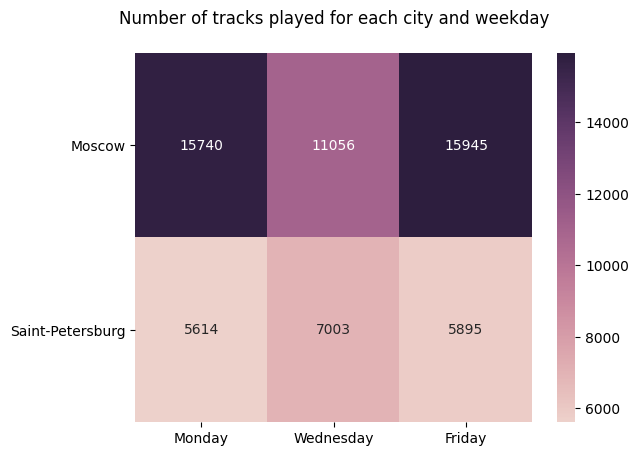

In [22]:
# Building a heatmap
info = pd.DataFrame(data=num_track_plays, columns=days, index=cities)
sns.heatmap(data=info, annot=True, fmt=".0f", cmap=sns.cubehelix_palette(as_cmap=True))
plt.yticks(rotation=0)
plt.title("Number of tracks played for each city and weekday\n")
plt.show()

**Conclusion (Hypothesis 1)**

Data shows difference in user behavior:

* Number of track plays in Moscow peaks on Monday and Friday, while it declines on Wednesday;
* In Saint-Petersburg, conversely, users listen to music more frequently on Wednesday.

Thus, the data confirms the first hypothesis: users from Moscow and Saint-Petersburg indeed listen to music differently.

### H2: Monday morning and Friday evening - different music or the same?

According to the second hypothesis, users in Moscow and Saint-Petersburg differ in their music genre preferences on Monday morning. Likewise, genres differ on Friday evening as well - depending on the city.

Let's create two variables and let them store two DataFrames, where each one will contain information about a specific city.

In [23]:
moscow_general = df[df["city"] == "Moscow"]
spb_general = df[df["city"] == "Saint-Petersburg"]

Now, in order to test the hypothesis, we need to define a function called `genre_weekday()` with four parameters:

* `df` - DataFrame with data;
* `day` - day of the week;
* `time1` - initial time stamp in 'hh:mm' format;
* `time2` - last time stamp in 'hh:mm' format.

The function will return information about top-10 genres of tracks played on a particular day between two time points.

In [24]:
def genre_weekday(data: pd.DataFrame, day: str, time1: str, time2: str) -> pd.Series:
    """Return information about top-10 most popular genres on a given day at a given time.

    Arguments:
    data (pd.DataFrame) -- DataFrame with musical preferences
    day (str) -- day of the week
    time1 (str) -- start of time period [hh:mm]
    time2 (str) -- end of time period [hh:mm]
    """
    genre_df = data[data["day"] == day]
    genre_df = genre_df[(genre_df["time"] > time1) & (genre_df["time"] < time2)]

    # Compiling a rating of the most popular genres
    genre_df_sorted = (
        genre_df.groupby("genre")["genre"].count().sort_values(ascending=False)
    )

    return genre_df_sorted[:10]

In [25]:
# Computing the number of track plays in Moscow on Monday morning
genre_weekday(data=moscow_general, day="Monday", time1="07:00", time2="11:00")

genre
pop            781
dance          549
electronic     480
rock           474
hiphop         286
ruspop         186
world          181
rusrap         175
alternative    164
unknown        161
Name: genre, dtype: int64

In [26]:
# Computing the number of track plays in Saint-Petersburg on Monday morning
genre_weekday(data=spb_general, day="Monday", time1="07:00", time2="11:00")

genre
pop            218
dance          182
rock           162
electronic     147
hiphop          80
ruspop          64
alternative     58
rusrap          55
jazz            44
classical       40
Name: genre, dtype: int64

In [27]:
# Computing the number of track plays in Moscow on Friday evening
genre_weekday(data=moscow_general, day="Friday", time1="17:00", time2="23:00")

genre
pop            713
rock           517
dance          495
electronic     482
hiphop         273
world          208
ruspop         170
alternative    163
classical      163
rusrap         142
Name: genre, dtype: int64

In [28]:
# Computing the number of track plays in Saint-Petersburg on Friday evening
genre_weekday(data=spb_general, day="Friday", time1="17:00", time2="23:00")

genre
pop            256
electronic     216
rock           216
dance          210
hiphop          97
alternative     63
jazz            61
classical       60
rusrap          59
world           54
Name: genre, dtype: int64

**Conclusion (Hypothesis 2)**

By comparing the top-10 genres on Monday morning, the following conclusion can be drawn:

* Users in Moscow and Saint-Petersburg listen to similar music. The only difference is that Moscow rating includes `world` genre, while that for Saint-Petersburg includes `jazz` and `classical` music genres.
* In Moscow there are so many missing values that `unknown` genre took the 10th place in the rating of the most popular genres. Hence, missing values account for a substantial fraction of data and are highly likely to affect the results. 
* Friday evening does not change the results: some genres ascend and descend across the top-10 rating but in general rating stays the same. 

Thus, the second hypothesis has been partially confirmed:

* Users listen to similar music at the beginning and the end of the week. 
* We were not able to detect a distinct difference between Moscow and Saint-Petersburg. Users in Moscow often listen to the russian popular music (`ruspop`), while users in Saint-Peterburg - jazz (`jazz`). 

However, missing values do not allow accurately confirming the above results. Moscow data has so many of them that it is likely that the top-10 rating could have looked differently should we have had all information.

### H3: Moscow and Saint-Petersburg - two different capitals with different music preferences?

The third hypothesis states that Saint-Petersburg is a city where `rusrap` genre prevails, while Moscow is popular with `pop`.

We can start by grouping the table by genre and counting the number of tracks played in Moscow.

In [29]:
moscow_general.groupby("genre")["genre"].count().sort_values(ascending=False).head(10)

genre
pop            5892
dance          4435
rock           3965
electronic     3786
hiphop         2096
classical      1616
world          1432
alternative    1379
ruspop         1372
rusrap         1161
Name: genre, dtype: int64

We can do the same exercise for Saint-Peterburg.

In [30]:
spb_general.groupby("genre")["genre"].count().sort_values(ascending=False).head(10)

genre
pop            2431
dance          1932
rock           1879
electronic     1736
hiphop          960
alternative     649
classical       646
rusrap          564
ruspop          538
world           515
Name: genre, dtype: int64

**Conclusion (Hypothesis 3)**

The third hypothesis has been partially confirmed:

* Pop-music (`pop`) is the most popular genre in Moscow as the hypothesis stipulated. Besides, top-10 genres also include a closer music genre - russian pop music (`ruspop`).
* Contrary to expectations, `rusrap` is as popular in Moscow as it is in Saint-Petersburg.

## General results

We have managed to test the following working hypotheses:

* There are differences in musical preferences in Moscow and Saint-Petersburg;
* Top-10 rating of popular genres on Monday morning and Friday evening can be characterized by distinct differences;
* Population of two cities prefers different music genres.

**Key takeaways**

Moscow and Saint-Petersburg are similar in musical tastes: pop music is preferred everywhere. Additionally, it is not contingent upon weekday: people always listen to what they like. However, comparing by weekday, Moscow users listen to music more on Monday and Friday than Wednesday, while in Saint-Peterburg the reverse takes place: users play tracks more frequently on Wednesday relative to Monday and Friday.

Thus, the first hypothesis has been confirmed and the other two - partially confirmed.